In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(9, 1)  # 3*3 = 9
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debugging statement
        x = self.conv_layers(x)
        print(f"Shape after conv layers: {x.shape}")  # Debugging statement
        x = self.flatten(x)
        print(f"Shape after flattening: {x.shape}")  # Debugging statement
        x = self.fc(x)
        x = self.sigmoid(x)
        print(f"Output shape: {x.shape}")  # Debugging statement
        return x


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load MNIST data and use a smaller subset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Use a smaller subset of the dataset
subset_indices = list(range(1000))  # Use first 1000 samples
train_subset = Subset(train_data, subset_indices)
test_subset = Subset(test_data, subset_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

# Create masks
def create_mask(images):
    masked_images = images.clone()
    mask = torch.ones_like(images)
    for img in masked_images:
        x = np.random.randint(0, img.shape[1] // 2)
        y = np.random.randint(0, img.shape[2] // 2)
        img[:, x:x+14, y:y+14] = 0
        mask[:, x:x+14, y:y+14] = 0
    return masked_images, mask

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 3, 1)  # 3*3 = 9
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debugging statement
        x = self.conv_layers(x)
        print(f"Shape after conv layers: {x.shape}")  # Debugging statement
        x = self.flatten(x)
        print(f"Shape after flattening: {x.shape}")  # Debugging statement
        x = self.fc(x)
        x = self.sigmoid(x)
        print(f"Output shape: {x.shape}")  # Debugging statement
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training
epochs = 10  # Reduce the number of epochs
for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        masked_images, masks = create_mask(real_images)
        masked_images = masked_images.to(device)
        masks = masks.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        
        real_input = torch.cat((real_images, masked_images), 1)
        real_output = discriminator(real_input)
        d_loss_real = criterion(real_output, real_labels)

        fake_images = generator(torch.cat((masked_images, masks), 1))
        fake_input = torch.cat((fake_images, masked_images), 1)
        fake_output = discriminator(fake_input.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_input)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if batch_idx % 10 == 0:  # Reduce print frequency
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Input shape: torch.Size([128, 2, 28, 28])
Shape after conv layers: torch.Size([128, 1, 3, 3])
Shape after flattening: torch.Size([128, 9])
Output shape: torch.Size([128, 1])
Input shape: torch.Size([128, 2, 28, 28])
Shape after conv layers: torch.Size([128, 1, 3, 3])
Shape after flattening: torch.Size([128, 9])
Output shape: torch.Size([128, 1])
Input shape: torch.Size([128, 2, 28, 28])
Shape after conv layers: torch.Size([128, 1, 3, 3])
Shape after flattening: torch.Size([128, 9])
Output shape: torch.Size([128, 1])
Epoch [1/10], Batch [0/8], D Loss: 0.7299745082855225, G Loss: 0.9955025911331177
Input shape: torch.Size([128, 2, 28, 28])
Shape after conv layers: torch.Size([128, 1, 3, 3])
Shape after flattening: torch.Size([128, 9])
Output shape: torch.Size([128, 1])
Input shape: torch.Size([128, 2, 28, 28])
Shape after conv layers: torch.Size([128, 1, 3, 3])
Shape after flattening: torch.Size([128, 9])
Output shape: torch.Size([128, 1])
Input shape: torch.Size([128, 2, 28, 28])
Shape 

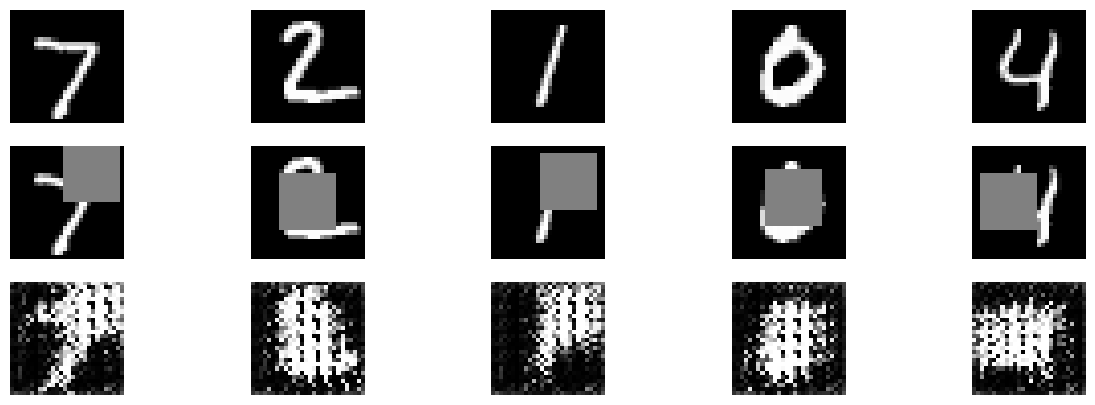

In [13]:
def plot_results(masked_imgs, gen_imgs, orig_imgs, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(orig_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        
        # Masked images
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(masked_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        
        # Generated images
        ax = plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(gen_imgs[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate some images to visualize
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)
masked_test_images, test_masks = create_mask(test_images)
generated_images = generator(torch.cat((masked_test_images, test_masks), 1))

plot_results(masked_test_images, generated_images, test_images)


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load MNIST data and use a slightly larger subset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Use a larger subset of the dataset
subset_indices = list(range(5000))  # Use first 5000 samples
train_subset = Subset(train_data, subset_indices)
test_subset = Subset(test_data, subset_indices)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=128, shuffle=False)

# Create masks
def create_mask(images):
    masked_images = images.clone()
    mask = torch.ones_like(images)
    for img in masked_images:
        x = np.random.randint(0, img.shape[1] // 2)
        y = np.random.randint(0, img.shape[2] // 2)
        img[:, x:x+14, y:y+14] = 0
        mask[:, x:x+14, y:y+14] = 0
    return masked_images, mask

# Define the Generator with a slightly improved architecture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the Discriminator with a slightly improved architecture
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3 * 3, 1)  # 3*3 = 9
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Debugging statement
        x = self.conv_layers(x)
        print(f"Shape after conv layers: {x.shape}")  # Debugging statement
        x = self.flatten(x)
        print(f"Shape after flattening: {x.shape}")  # Debugging statement
        x = self.fc(x)
        x = self.sigmoid(x)
        print(f"Output shape: {x.shape}")  # Debugging statement
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Learning rate scheduler
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=1, gamma=0.9)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=1, gamma=0.9)

# Training
epochs = 10  # Increase the number of epochs
for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        masked_images, masks = create_mask(real_images)
        masked_images = masked_images.to(device)
        masks = masks.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        
        real_input = torch.cat((real_images, masked_images), 1)
        real_output = discriminator(real_input)
        d_loss_real = criterion(real_output, real_labels)

        fake_images = generator(torch.cat((masked_images, masks), 1))
        fake_input = torch.cat((fake_images, masked_images), 1)
        fake_output = discriminator(fake_input.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_input)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        if batch_idx % 10 == 0:  # Reduce print frequency
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    # Update learning rate
    scheduler_G.step()
    scheduler_D.step()

# Visualize Results
def plot_results(masked_imgs, gen_imgs, orig_imgs, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(orig_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        
        # Masked images
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(masked_imgs[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        
        # Generated images
        ax = plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(gen_imgs[i].cpu().detach().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate some images to visualize
test_images, _ = next(iter(test_loader))
test_images = test_images.to(device)
masked_test_images, test_masks = create_mask(test_images)
generated_images = generator(torch.cat((masked_test_images, test_masks), 1))

plot_results(masked_test_images, generated_images, test_images)


Input shape: torch.Size([128, 2, 28, 28])
Shape after conv layers: torch.Size([128, 1, 1, 1])
Shape after flattening: torch.Size([128, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 9x1)